# Debt Price Driven Model

## Overview

The purpose of this experiment is to tune and test the PI controller, by driving the debt price directly.

## Shared setup and dependencies

In [1]:
from shared import *

In [2]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: fn, funcy, pathos, pandas
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Parameters

These are the key model parameters:
* `options.DebtPriceSource == options.DebtPriceSource.EXTERNAL`, with a step input sweep set as the debt price external data source, and a market model trained using historical debt price data.

In [3]:
seconds_week = 604800
timesteps = int(10 * seconds_week / 3600)
control_period = 3600
shock_timestep = 1 * seconds_week / 3600
shock_duration = 5 * seconds_week / 3600

price_moves = [
    #lambda timestep: 0.01 if timestep == 50 else (-0.01 if timestep == 250 else 0),
    #lambda timestep: 0.05 if timestep == 50 else (-0.05 if timestep == 250 else 0),
    #lambda timestep: 0.1 if timestep == 50 else (-0.1 if timestep == 250 else 0)
    #lambda timestep, df=df.copy(): float(df.iloc[timestep - 1]['price_move'])
    #for df in debt_price_data,
    lambda timestep: 0.05 if timestep == shock_timestep else (-0.05 if timestep == shock_timestep + 1 else 0),
    lambda timestep: 0.05 if timestep == shock_timestep else (-0.05 if timestep == shock_timestep + shock_duration  else 0),
    lambda timestep: 0.05/50 * np.sin(timestep * 0.05)
]

* PI controller constant sweep

In [4]:
kp_sweep = [-1e-6]
ki_sweep = [lambda control_period=3600: 0]

controller_sweep = list(itertools.product(kp_sweep, ki_sweep))
controller_sweep

kp_sweep = [x[0] for x in controller_sweep]
ki_sweep = [x[1] for x in controller_sweep]

print(kp_sweep)
print(ki_sweep)

[-1e-06]
[<function <lambda> at 0x118fa3ca0>]


* Error term calculation

In [5]:
error_term = [
    lambda target, measured: target - measured,
    #lambda target, measured: (target - measured) / measured,
    #lambda target, measured: (target - measured) / target
]

* Integral type

In [6]:
integral_type = [options.IntegralType.DEFAULT.value]

## Simulation Configuration

Set the simulation timesteps to the minimum dataset length:

In [7]:
SIMULATION_TIMESTEPS = range(timesteps)

Override certain parameter sweeps with the generated sets, using ConfigWrapper for convenience:

In [8]:
# Update parameter options
update_params = {
    # By using an Enum, we can self-document all possible options
    options.DebtPriceSource.__name__: [options.DebtPriceSource.EXTERNAL.value],
    options.MarketPriceSource.__name__: [options.MarketPriceSource.DEFAULT.value],
    options.IntegralType.__name__: integral_type,
    'controller_enabled': [True],
    'expected_control_delay': [lambda _timestep: 0], # 1200 # stochastic process
    'minumum_control_period': [lambda _timestep: control_period],
    # Generate a lambda for each test dataframe, that returns a row value at a specific timestep
    'price_move': price_moves,
    'kp': kp_sweep,
    'ki': ki_sweep,
    # Select or sweep the error term calculation, as a lambda
    # e.g. p*-p vs (p*-p)/p vs (p*-p)/p*
    'error_term': error_term,
}

'''
The ConfigWrapper allows you to pass a model as an argument, and update the simulation configuration.
Maps (params, states) would be merge updated, and all other options are overrides.
'''
system_simulation = ConfigWrapper(system_model, M=update_params, N=1, T=SIMULATION_TIMESTEPS)

## Simulation Execution

In [9]:
del configs[:]

system_simulation.append()

(data, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1680, 23, 3, 15)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 1, 2]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 3.26s


## Data Analysis

In [10]:
df = data.copy()
df

index  error_star  error_hat  old_error_star  old_error_hat  \
0         0    0.000000   0.000000             0.0            0.0   
1         6    0.002300   0.002300             0.0            0.0   
2        12    0.003379   0.003387             0.0            0.0   
3        18    0.004067   0.004088             0.0            0.0   
4        24    0.004267   0.004302             0.0            0.0   
...     ...         ...        ...             ...            ...   
5038  30218   -0.015643  -0.003717             0.0            0.0   
5039  30224   -0.016302  -0.003606             0.0            0.0   
5040  30230   -0.016919  -0.003486             0.0            0.0   
5041  30236   -0.017495  -0.003357             0.0            0.0   
5042  30242   -0.018027  -0.003220             0.0            0.0   

      error_star_integral  error_hat_integral  error_star_derivative  \
0                0.000000            0.000000           0.000000e+00   
1                4.140000            4.140000           6.388889e-07   
2               14.361453           14.376357           2.996070e-07   
3               27.764382           27.830987           1.913616e-07   
4               42.766682           42.933237           5.545493e-08   
...                   ...                 ...                    ...   
5038        -18761.593446          872.746312          -1.936901e-07   
5039        -18819.094492          859.565621          -1.828681e-07   
5040        -18878.892418          846.800311          -1.715887e-07   
5041        -18940.838264          834.482333          -1.598803e-07   
5042        -19004.777695          822.642519          -1.477719e-07   

      error_hat_derivative   target_rate  ...  market_price  debt_price  \
0             0.000000e+00  0.000000e+00  ...      1.000000    1.000000   
1             6.388889e-07 -2.300000e-09  ...      0.997700    1.000000   
2             2.996070e-07 -3.378585e-09  ...      0.996613    1.000000   
3             1.913616e-07 -4.067487e-09  ...      0.995912    1.000000   
4             5.545493e-08 -4.267124e-09  ...      0.995698    1.000000   
...                    ...           ...  ...           ...         ...   
5038         -1.936901e-07  1.564335e-08  ...      1.034553    1.030837   
5039         -1.828681e-07  1.630168e-08  ...      1.035269    1.031663   
5040         -1.715887e-07  1.691939e-08  ...      1.035947    1.032461   
5041         -1.598803e-07  1.749496e-08  ...      1.036584    1.033227   
5042         -1.477719e-07  1.802694e-08  ...      1.037180    1.033960   

      timedelta           timestamp blockheight  simulation  subset  run  \
0             0 2018-12-18 00:00:00           0           0       0    1   
1          3600 2018-12-18 01:00:00         240           0       0    1   
2          3600 2018-12-18 02:00:00         480           0       0    1   
3          3600 2018-12-18 03:00:00         720           0       0    1   
4          3600 2018-12-18 04:00:00         960           0       0    1   
...         ...                 ...         ...         ...     ...  ...   
5038       3600 2019-02-25 20:00:00      402240           0       2    2   
5039       3600 2019-02-25 21:00:00      402480           0       2    2   
5040       3600 2019-02-25 22:00:00      402720           0       2    2   
5041       3600 2019-02-25 23:00:00      402960           0       2    2   
5042       3600 2019-02-26 00:00:00      403200           0       2    2   

      substep  timestep  
0           0         0  
1           6         1  
2           6         2  
3           6         3  
4           6         4  
...       ...       ...  
5038        6      1676  
5039        6      1677  
5040        6      1678  
5041        6      1679  
5042        6      1680  

[5043 rows x 21 columns]

In [11]:
df['target_rate_hourly'] = df.target_rate # * 3600
df['error_star_derivative_scaled'] = df.error_star_derivative * 3600
df['error_hat_derivative_scaled'] = df.error_star_derivative * 3600

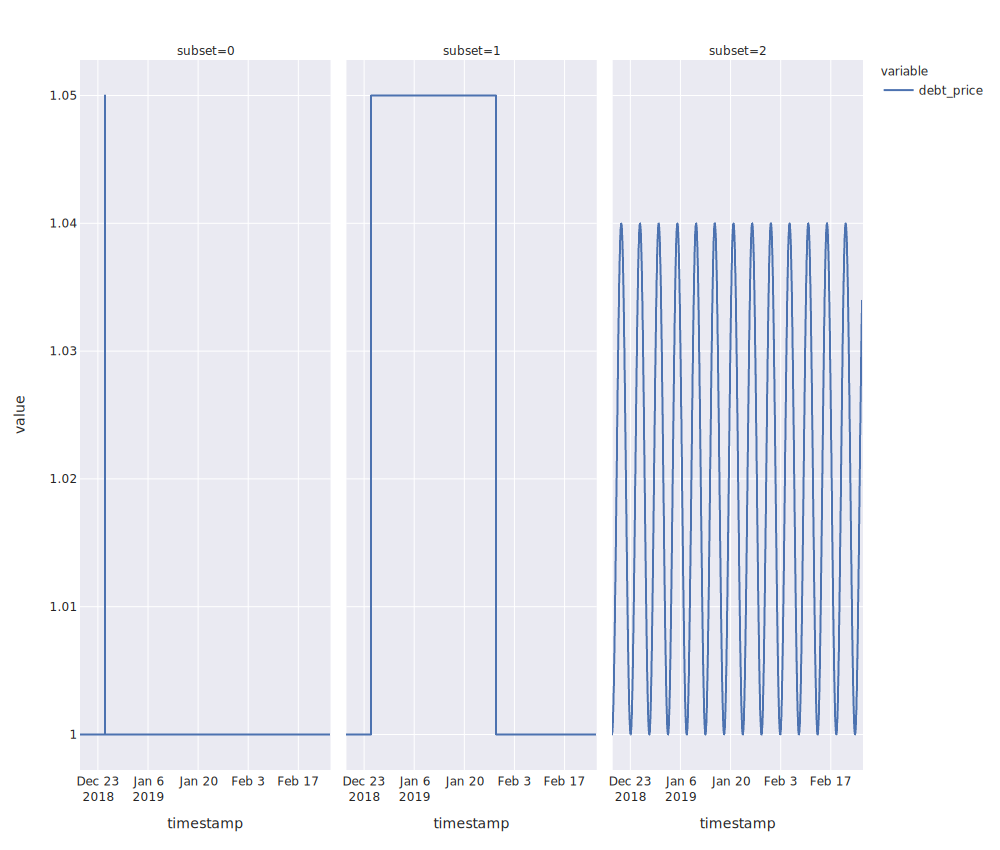

In [12]:
fig = px.line(
    df,
    x='timestamp',
    y=['debt_price'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_debt_price/debt_price.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_debt_price/debt_price.svg'))

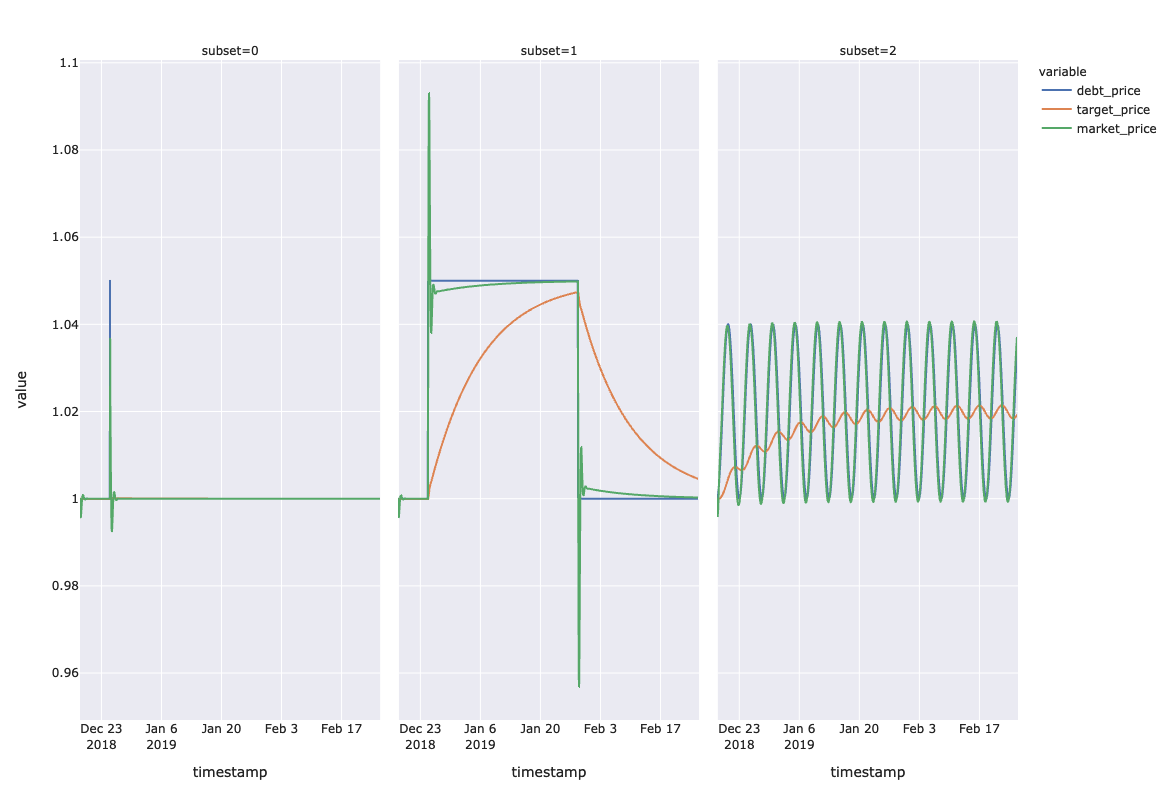

In [13]:
fig = px.line(
    df,
    x='timestamp',
    y=['debt_price', 'target_price', 'market_price'],
    facet_col_wrap=3,
    facet_col='subset',
    template='seaborn',
    height=800
)

# fig.for_each_annotation(lambda a: a.update(text=f'''price_move:{
#     debt_price_data[int(a.text.split("=")[-1])].price_move.max()
# }'''))

fig.show()
# fig.write_image('plots/notebook_validation_debt_price/response.svg', width=1000, height=850)
# from IPython.display import SVG,display
# display(SVG(filename='plots/notebook_validation_debt_price/response.svg'))

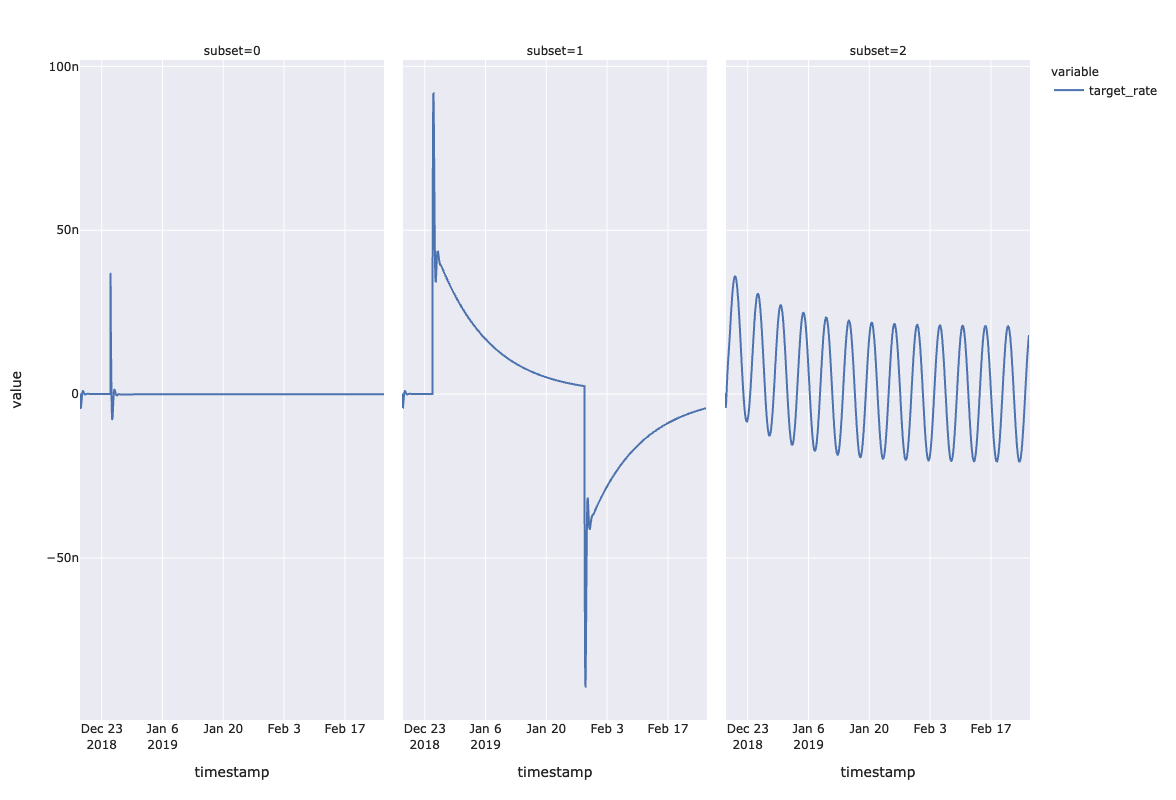

In [14]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_rate'],
    facet_col_wrap=3,
    facet_col='subset',
    template='seaborn',
    height=800
)

fig.show()

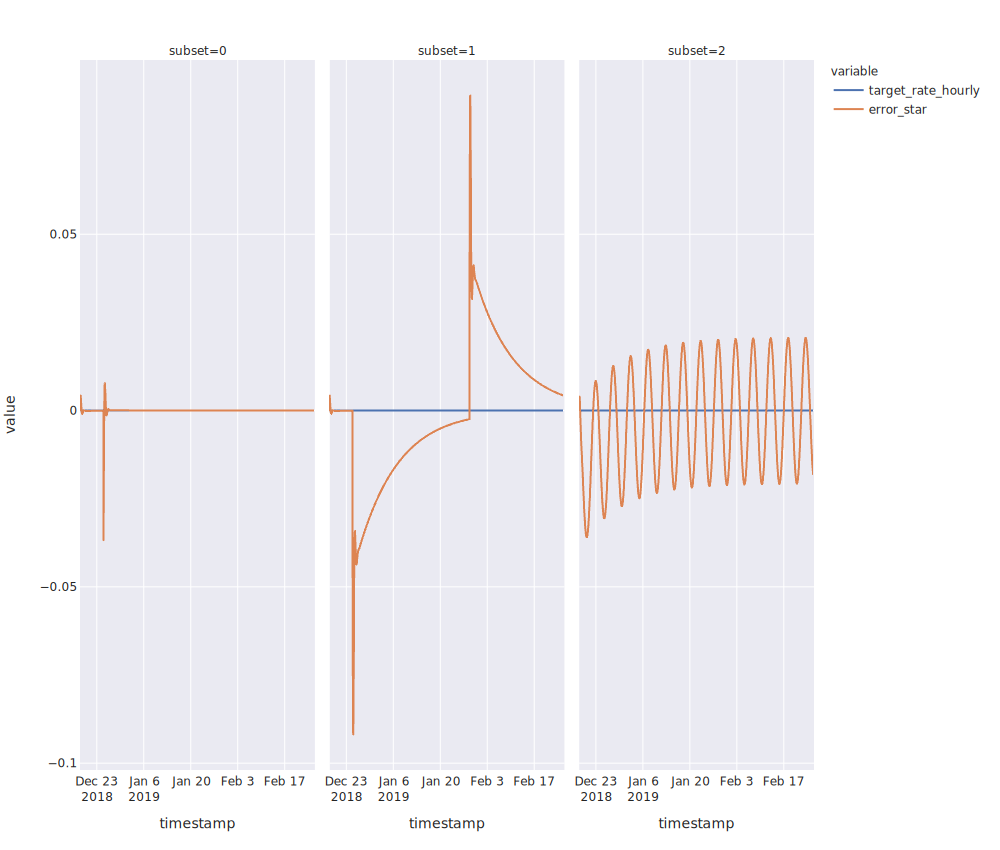

In [15]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_rate_hourly', 'error_star'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_debt_price/target_rate.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_debt_price/target_rate.svg'))

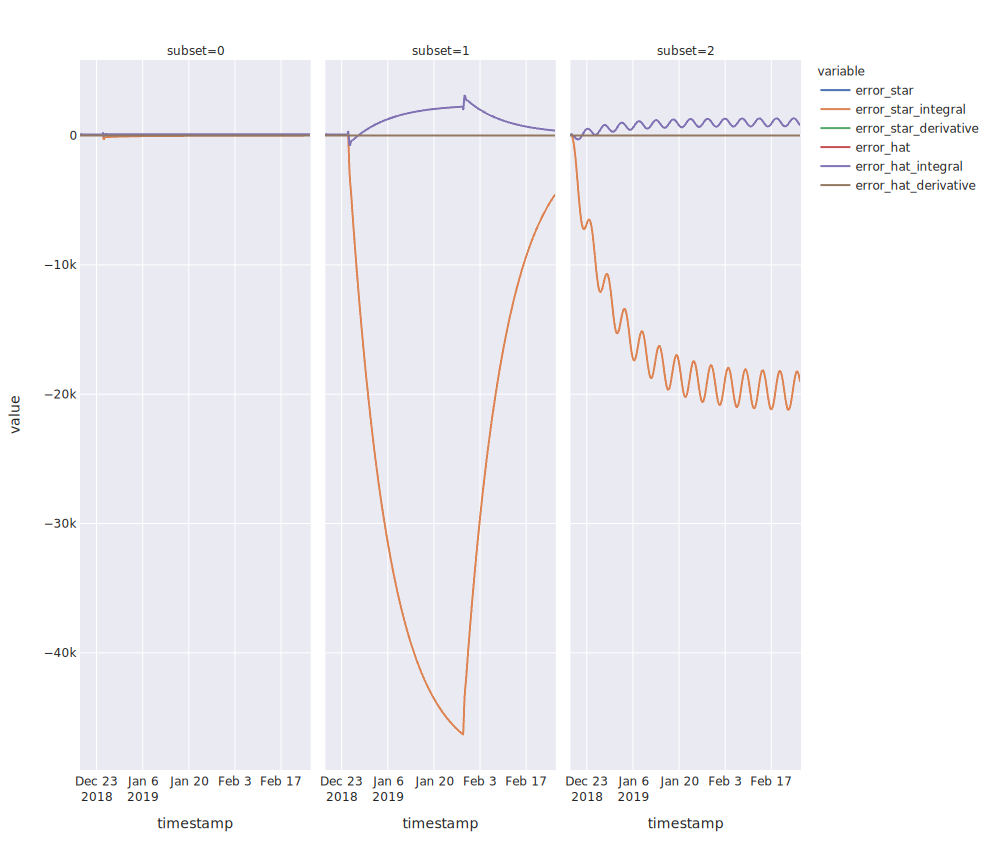

In [16]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star', 'error_star_integral', 'error_star_derivative', 'error_hat', 'error_hat_integral', 'error_hat_derivative'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_debt_price/error_star.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_debt_price/error_star.svg'))

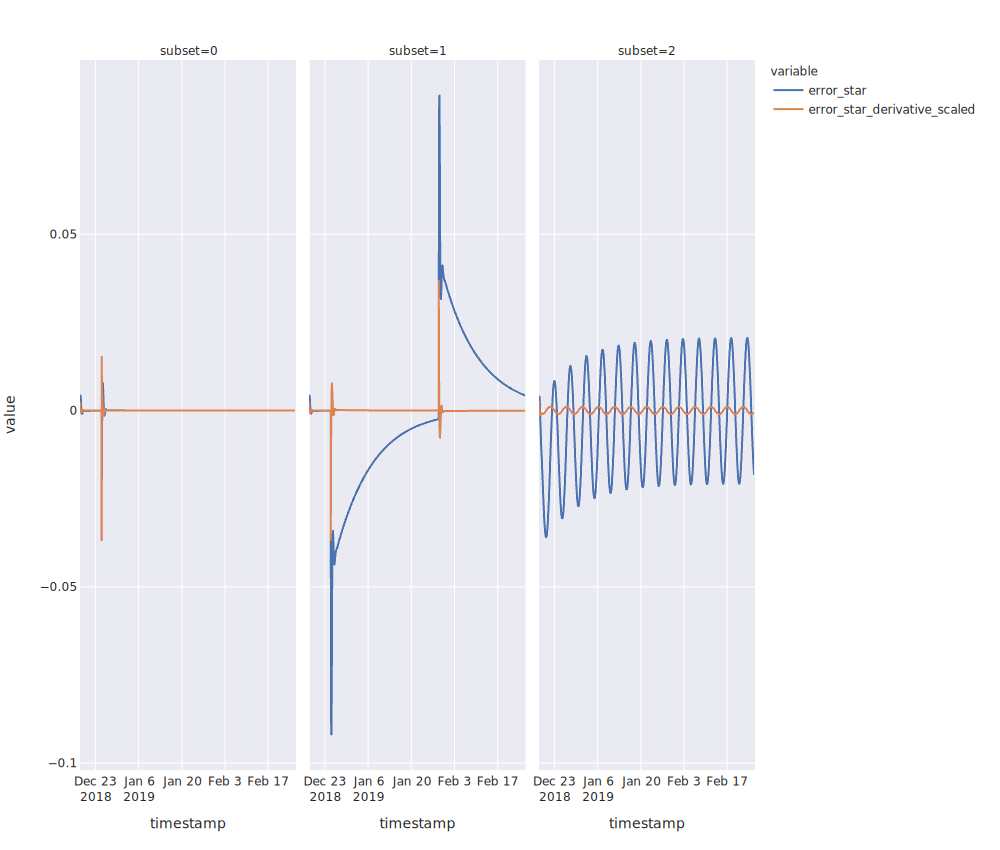

In [17]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star','error_star_derivative_scaled'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_debt_price/error_star_derivative.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_debt_price/error_star_derivative.svg'))

## Controller Metrics

In [18]:
for subset in range(df.subset.max() + 1):
    dataset = df.query(f'subset == {subset}')
    
    pv_initial = dataset['debt_price'].iloc[0]
    pv_max = dataset['debt_price'][dataset.index[-1]]

    target_initial = dataset[dataset.target_price > pv_initial].iloc[0]

    time_constant = dataset[dataset.target_price - pv_initial >= 0.63 * (pv_max - pv_initial)].iloc[0].timestamp - target_initial.timestamp

    print(f'Controller time constant for subset {subset}: {time_constant}')

Controller time constant for subset 0: -8 days +23:00:00
Controller time constant for subset 1: -8 days +23:00:00
Controller time constant for subset 2: 65 days 18:00:00


In [19]:
for subset in range(df.subset.max() + 1):
    dataset = df.query(f'subset == {subset}')
    print(f'Overshoot for subset {subset}: {(dataset.market_price.max() - dataset.debt_price.max()) / dataset.debt_price.max()}')

Overshoot for subset 0: -0.012653030899152479
Overshoot for subset 1: 0.04101954327606627
Overshoot for subset 2: 0.0006456328628737469


In [20]:
for subset in range(df.subset.max() + 1):
    dataset = df.query(f'subset == {subset}')
    diff = dataset.debt_price - dataset.market_price
    mean_diff = diff.sum()/dataset.timestep.max()
    print(f'Mean difference for subset {subset}: {mean_diff}')

Mean difference for subset 0: 1.6285955427732112e-05
Mean difference for subset 1: 6.459234259179192e-05
Mean difference for subset 2: 0.00013506050510842413


In [21]:
for subset in range(df.subset.max() + 1):
    dataset = df.query(f'subset == {subset}')
    diff = dataset.debt_price - dataset.market_price
    stats = diff.describe()
    print(f'Stats for subset {subset}\n {stats} \n')

Stats for subset 0
 count    1.681000e+03
mean     1.627627e-05
std      1.760683e-03
min     -3.671432e-02
25%     -1.590323e-06
50%     -3.830771e-07
75%     -9.290509e-08
max      5.000319e-02
dtype: float64 

Stats for subset 1
 count    1681.000000
mean        0.000065
std         0.004185
min        -0.049841
25%        -0.000662
50%         0.000167
75%         0.000723
max         0.050003
dtype: float64 

Stats for subset 2
 count    1681.000000
mean        0.000135
std         0.003049
min        -0.004280
25%        -0.002914
50%         0.000061
75%         0.003180
max         0.005146
dtype: float64 

